# Kaplan-Meier Survival Curves & Sankey Diagram

This notebook builds on the treatment effect analysis to produce:

1. **Kaplan-Meier survival curves** comparing treated vs untreated simulants
   - Set 1: Time zero = BBBM entry (CRN-matched cross-scenario comparison)
   - Set 2: Time zero = treatment decision (within-scenario treated vs refused)
2. **Sankey diagram** explaining why 71.8% of treated simulants show zero benefit

### Events analyzed
- **Progression to MCI** (BBBM exit via disease transition)
- **All-cause death** (any cause)
- **AD-associated death** (death while in dementia state; only dementia has EMR > 0)

In [1]:
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from loguru import logger
from tqdm.auto import tqdm
from vivarium import InteractiveContext

# Suppress vivarium's verbose INFO logging (uses loguru, not stdlib logging)
logger.disable("vivarium")

SPEC_PATH = '../src/vivarium_csu_alzheimers/model_specifications/model_spec.yaml'
POPULATION_SIZE = 10_000
STEP_SIZE_DAYS = 182
STEP_SIZE_YEARS = STEP_SIZE_DAYS / 365.25

BBBM_STATE = 'alzheimers_blood_based_biomarker_state'
MCI_STATE = 'alzheimers_mild_cognitive_impairment_state'
DEMENTIA_STATE = 'alzheimers_disease_state'
DISEASE_COL = 'alzheimers_disease_and_other_dementias'
TREATMENT_COL = 'treatment'

TARGET_YEAR = 2070

# Treatment relative risk from artifact (draw_0)
TREATMENT_RR = 0.528

## Data Collection

Enhanced tracking function that records:
- BBBM entry/exit times and destinations
- Treatment pipeline entry and state at BBBM exit
- **Disease state at death** for all simulants (to identify AD-associated deaths)
- **Treatment refusal time** (`no_effect_never_treated` entry) for KM Set 2
- **Treatment state at BBBM exit** collected *before* the step (to avoid component-ordering artifacts)

In [2]:
def run_scenario_with_tracking(scenario, target_year=TARGET_YEAR):
    """Run a scenario with enhanced per-simulant tracking for KM and Sankey analysis."""
    sim = InteractiveContext(
        SPEC_PATH,
        configuration={
            'population': {'population_size': POPULATION_SIZE},
            'intervention': {'scenario': scenario},
        }
    )

    target = pd.Timestamp(f'{target_year}-01-01')
    est_steps = max(1, math.ceil((target - sim.current_time).days / STEP_SIZE_DAYS))

    # Per-simulant tracking
    in_bbbm = set()
    alive_set = set()
    bbbm_enter_time = {}      # sid -> first BBBM entry timestamp
    bbbm_exit_time = {}       # sid -> first BBBM exit timestamp
    bbbm_exit_to = {}         # sid -> 'mci' | 'dead'
    death_time = {}           # sid -> death timestamp
    disease_at_death = {}     # sid -> cause of death
    treatment_pipeline_time = {}  # sid -> first non-susceptible treatment state time
    treatment_refusal_time = {}   # sid -> time entering no_effect_never_treated
    treatment_state_at_exit = {}  # sid -> treatment state when leaving BBBM

    # Snapshot of treatment states BEFORE each step (for accurate exit tracking)
    prev_treatment_states = {}  # sid -> treatment state from previous step

    with tqdm(total=est_steps, desc=scenario.replace('bbbm_', ''), unit='step') as pbar:
        while sim.current_time < target:
            # Capture pre-step treatment states for simulants currently in BBBM
            if scenario == 'bbbm_testing_and_treatment' and in_bbbm:
                pop_pre = sim.get_population()
                alive_pre = pop_pre[pop_pre['alive'] == 'alive']
                for sid in in_bbbm:
                    if sid in alive_pre.index and TREATMENT_COL in alive_pre.columns:
                        prev_treatment_states[sid] = alive_pre.loc[sid, TREATMENT_COL]

            sim.step()
            pop = sim.get_population()
            alive = pop[pop['alive'] == 'alive']
            t = sim.current_time
            current_alive = set(alive.index)

            # Track deaths
            newly_dead = alive_set - current_alive
            for sid in newly_dead:
                if sid not in death_time:
                    death_time[sid] = t
                    # Get cause of death from full pop (dead simulants still have columns)
                    if sid in pop.index:
                        disease_at_death[sid] = pop.loc[sid, 'cause_of_death']

            # Track BBBM entry/exit
            currently_bbbm = set(alive.index[alive[DISEASE_COL] == BBBM_STATE])

            new_bbbm = currently_bbbm - in_bbbm
            for sid in new_bbbm:
                if sid not in bbbm_enter_time:
                    bbbm_enter_time[sid] = t

            exited_bbbm = in_bbbm - currently_bbbm
            for sid in exited_bbbm:
                if sid not in bbbm_exit_time:
                    bbbm_exit_time[sid] = t
                    if sid in current_alive:
                        bbbm_exit_to[sid] = 'mci'  # only MCI follows BBBM
                    else:
                        bbbm_exit_to[sid] = 'dead'
                    # Use pre-step treatment state to avoid component-ordering artifacts
                    if sid in prev_treatment_states:
                        treatment_state_at_exit[sid] = prev_treatment_states[sid]
                    elif TREATMENT_COL in pop.columns:
                        treatment_state_at_exit[sid] = pop.loc[sid, TREATMENT_COL]

            in_bbbm = currently_bbbm
            alive_set = current_alive

            # Track treatment pipeline entry and refusal
            if scenario == 'bbbm_testing_and_treatment' and TREATMENT_COL in alive.columns:
                pipeline_states = [
                    'waiting_for_treatment', 'treatment_effect',
                    'waning_effect', 'no_effect_after_treatment',
                ]
                for sid in alive.index:
                    state = alive.loc[sid, TREATMENT_COL]
                    if state in pipeline_states and sid not in treatment_pipeline_time:
                        treatment_pipeline_time[sid] = t
                    if state == 'no_effect_never_treated' and sid not in treatment_refusal_time:
                        treatment_refusal_time[sid] = t

            pbar.update(1)

    return {
        'bbbm_enter_time': bbbm_enter_time,
        'bbbm_exit_time': bbbm_exit_time,
        'bbbm_exit_to': bbbm_exit_to,
        'death_time': death_time,
        'disease_at_death': disease_at_death,
        'treatment_pipeline_time': treatment_pipeline_time,
        'treatment_refusal_time': treatment_refusal_time,
        'treatment_state_at_exit': treatment_state_at_exit,
        'sim_end': sim.current_time,
    }

In [3]:
print('Running testing-only scenario...')
test_data = run_scenario_with_tracking('bbbm_testing')
print(f'  {len(test_data["bbbm_exit_time"])} BBBM exits')
print(f'  {len(test_data["death_time"])} deaths')

print('\nRunning testing+treatment scenario...')
treat_data = run_scenario_with_tracking('bbbm_testing_and_treatment')
print(f'  {len(treat_data["bbbm_exit_time"])} BBBM exits')
print(f'  {len(treat_data["death_time"])} deaths')
print(f'  {len(treat_data["treatment_pipeline_time"])} entered treatment pipeline')
print(f'  {len(treat_data["treatment_refusal_time"])} refused treatment')

Running testing-only scenario...


/home/abie/miniforge3/envs/vivarium_csu_alzheimers_simulation/lib/python3.11/site-packages/vivarium_public_health/plugins/parser.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


testing:   0%|          | 0/97 [00:00<?, ?step/s]

  86013 BBBM exits
  80574 deaths

Running testing+treatment scenario...


testing_and_treatment:   0%|          | 0/97 [00:00<?, ?step/s]

  85783 BBBM exits
  80497 deaths
  3969 entered treatment pipeline
  5487 refused treatment


In [4]:
# Build matched comparison DataFrame for treated simulants
sim_end = treat_data['sim_end']

rows = []
for sid in treat_data['treatment_pipeline_time']:
    # --- Treatment scenario data ---
    bbbm_enter_t = treat_data['bbbm_enter_time'].get(sid)
    bbbm_exit_t = treat_data['bbbm_exit_time'].get(sid)
    death_t = treat_data['death_time'].get(sid)
    disease_dead_t = treat_data['disease_at_death'].get(sid)
    pipeline_t = treat_data['treatment_pipeline_time'].get(sid)
    tx_state_exit = treat_data['treatment_state_at_exit'].get(sid, 'still_bbbm')

    # --- Testing-only scenario data (CRN-matched) ---
    bbbm_enter_c = test_data['bbbm_enter_time'].get(sid)
    bbbm_exit_c = test_data['bbbm_exit_time'].get(sid)
    death_c = test_data['death_time'].get(sid)
    disease_dead_c = test_data['disease_at_death'].get(sid)

    if bbbm_enter_t is None or bbbm_enter_c is None:
        continue

    rows.append({
        'sid': sid,
        # BBBM timing — treatment scenario
        'bbbm_enter_t': bbbm_enter_t,
        'bbbm_exit_t': bbbm_exit_t,          # None if still in BBBM
        'bbbm_exit_to_t': treat_data['bbbm_exit_to'].get(sid),
        'bbbm_censored_t': bbbm_exit_t is None,
        # BBBM timing — control scenario
        'bbbm_enter_c': bbbm_enter_c,
        'bbbm_exit_c': bbbm_exit_c,
        'bbbm_exit_to_c': test_data['bbbm_exit_to'].get(sid),
        'bbbm_censored_c': bbbm_exit_c is None,
        # Death timing
        'death_t': death_t,
        'death_c': death_c,
        'disease_at_death_t': disease_dead_t,
        'disease_at_death_c': disease_dead_c,
        # Treatment info
        'pipeline_time': pipeline_t,
        'tx_state_at_exit': tx_state_exit,
    })

treated_df = pd.DataFrame(rows)
print(f'Matched treated simulants: {len(treated_df)}')
print(f'  BBBM-censored (treatment): {treated_df["bbbm_censored_t"].sum()}')
print(f'  BBBM-censored (control):   {treated_df["bbbm_censored_c"].sum()}')

Matched treated simulants: 3969
  BBBM-censored (treatment): 937
  BBBM-censored (control):   707


## KM Curve Set 1: Time Zero = BBBM Entry

Compare **treated simulants** (treatment scenario) vs the **same simulants** in the
testing-only scenario (CRN-matched counterfactual). This is the cleanest causal comparison.

Three events:
- **(a) Progression to MCI** — event = transition from BBBM to MCI; censored at death or sim-end
- **(b) All-cause death** — event = death; censored at sim-end
- **(c) AD-associated death** — event = cause of death is AD; censored at non-AD death or sim-end

In [5]:
def build_km_data_set1(df, sim_end):
    """Build KM-ready DataFrames for Set 1 (time zero = BBBM entry).
    
    Returns dict with keys 'mci', 'death', 'dementia_death', each containing
    columns: duration_t, event_t, duration_c, event_c (treatment and control).
    """
    records = {'mci': [], 'death': [], 'dementia_death': []}

    for _, row in df.iterrows():
        # Time zero = BBBM entry (same in both scenarios due to CRN)
        t0_t = row['bbbm_enter_t']
        t0_c = row['bbbm_enter_c']

        # --- (a) MCI progression ---
        # Treatment scenario
        if row['bbbm_exit_to_t'] == 'mci':
            dur_t = (row['bbbm_exit_t'] - t0_t).days / 365.25
            evt_t = 1
        elif row['bbbm_exit_to_t'] == 'dead':
            dur_t = (row['bbbm_exit_t'] - t0_t).days / 365.25
            evt_t = 0  # censored at death
        else:  # still in BBBM
            dur_t = (sim_end - t0_t).days / 365.25
            evt_t = 0
        # Control scenario
        if row['bbbm_exit_to_c'] == 'mci':
            dur_c = (row['bbbm_exit_c'] - t0_c).days / 365.25
            evt_c = 1
        elif row['bbbm_exit_to_c'] == 'dead':
            dur_c = (row['bbbm_exit_c'] - t0_c).days / 365.25
            evt_c = 0
        else:
            dur_c = (sim_end - t0_c).days / 365.25
            evt_c = 0
        records['mci'].append({'duration_t': dur_t, 'event_t': evt_t,
                               'duration_c': dur_c, 'event_c': evt_c})

        # --- (b) All-cause death ---
        death_treat = row['death_t']
        if pd.notna(death_treat):
            dur_t = (death_treat - t0_t).days / 365.25
            evt_t = 1
        else:
            dur_t = (sim_end - t0_t).days / 365.25
            evt_t = 0
        death_ctrl = row['death_c']
        if pd.notna(death_ctrl):
            dur_c = (death_ctrl - t0_c).days / 365.25
            evt_c = 1
        else:
            dur_c = (sim_end - t0_c).days / 365.25
            evt_c = 0
        records['death'].append({'duration_t': dur_t, 'event_t': evt_t,
                                 'duration_c': dur_c, 'event_c': evt_c})

        # --- (c) AD-associated death ---
        if pd.notna(death_treat) and row['disease_at_death_t'] == DEMENTIA_STATE:
            dur_t = (death_treat - t0_t).days / 365.25
            evt_t = 1
        elif pd.notna(death_treat):
            dur_t = (death_treat - t0_t).days / 365.25
            evt_t = 0  # died but not from AD -> censored
        else:
            dur_t = (sim_end - t0_t).days / 365.25
            evt_t = 0
        if pd.notna(death_ctrl) and row['disease_at_death_c'] == DEMENTIA_STATE:
            dur_c = (death_ctrl - t0_c).days / 365.25
            evt_c = 1
        elif pd.notna(death_ctrl):
            dur_c = (death_ctrl - t0_c).days / 365.25
            evt_c = 0
        else:
            dur_c = (sim_end - t0_c).days / 365.25
            evt_c = 0
        records['dementia_death'].append({'duration_t': dur_t, 'event_t': evt_t,
                                         'duration_c': dur_c, 'event_c': evt_c})

    return {k: pd.DataFrame(v) for k, v in records.items()}

km1_data = build_km_data_set1(treated_df, sim_end)
for name, d in km1_data.items():
    n_events_t = d['event_t'].sum()
    n_events_c = d['event_c'].sum()
    print(f'{name:20s}: n={len(d)}, events(treated)={n_events_t}, events(control)={n_events_c}')

mci                 : n=3969, events(treated)=2193, events(control)=2703
death               : n=3969, events(treated)=2338, events(control)=2415
dementia_death      : n=3969, events(treated)=603, events(control)=788


In [6]:
def compute_hr(durations_t, events_t, durations_c, events_c):
    """Compute hazard ratio (treated vs control) using Cox PH regression.
    
    Returns (HR, lower_95_CI, upper_95_CI).
    HR < 1 means treated group has lower hazard (better outcome).
    """
    cox_df = pd.DataFrame({
        'duration': np.concatenate([durations_t.values, durations_c.values]),
        'event': np.concatenate([events_t.values, events_c.values]),
        'treated': np.concatenate([np.ones(len(durations_t)), np.zeros(len(durations_c))]),
    })
    # Filter out zero/negative durations
    cox_df = cox_df[cox_df['duration'] > 0]
    
    cph = CoxPHFitter()
    cph.fit(cox_df, duration_col='duration', event_col='event')
    
    hr = cph.hazard_ratios_['treated']
    ci = cph.confidence_intervals_.loc['treated']
    hr_lower = np.exp(ci.iloc[0])
    hr_upper = np.exp(ci.iloc[1])
    
    return hr, hr_lower, hr_upper, cph


def plot_km_pair(ax, durations_t, events_t, durations_c, events_c,
                 label_t='Treated', label_c='Untreated (CRN match)',
                 title='', ylabel='Survival probability', xlim=None):
    """Plot KM curves for treated vs control on a single axes, with HR annotation."""
    kmf_t = KaplanMeierFitter()
    kmf_c = KaplanMeierFitter()

    kmf_t.fit(durations_t, event_observed=events_t, label=label_t)
    kmf_c.fit(durations_c, event_observed=events_c, label=label_c)

    kmf_t.plot_survival_function(ax=ax, color='#2ca02c', linewidth=2)
    kmf_c.plot_survival_function(ax=ax, color='#d62728', linewidth=2, linestyle='--')

    # Log-rank test
    lr_result = logrank_test(durations_t, durations_c, events_t, events_c)
    p = lr_result.p_value
    p_str = 'p < 0.001' if p < 0.001 else f'p = {p:.3f}'

    # Cox PH hazard ratio
    hr, hr_lo, hr_hi, cph = compute_hr(durations_t, events_t, durations_c, events_c)

    ax.text(0.5, 0.5,
            f'Log-rank: {p_str}\nHR = {hr:.3f} ({hr_lo:.3f}\u2013{hr_hi:.3f})',
            transform=ax.transAxes, ha='right', va='center', fontsize=9,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='wheat', alpha=0.8))

    ax.set_title(title, fontsize=11)
    ax.set_xlabel('Years since BBBM entry')
    ax.set_ylabel(ylabel)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.02, 1.02)
    if xlim is not None:
        ax.set_xlim(xlim)

    return {'logrank': lr_result, 'hr': hr, 'hr_ci': (hr_lo, hr_hi), 'cph': cph}

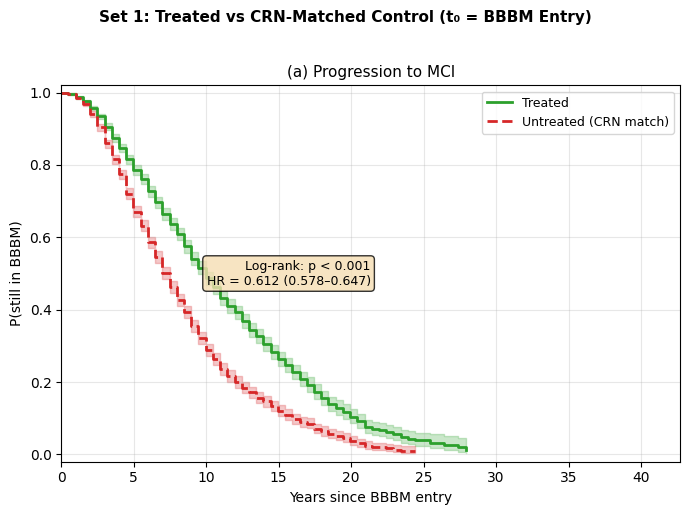

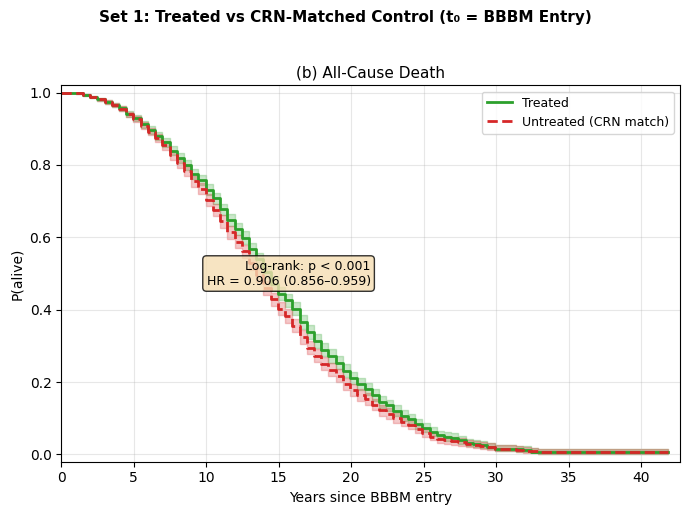

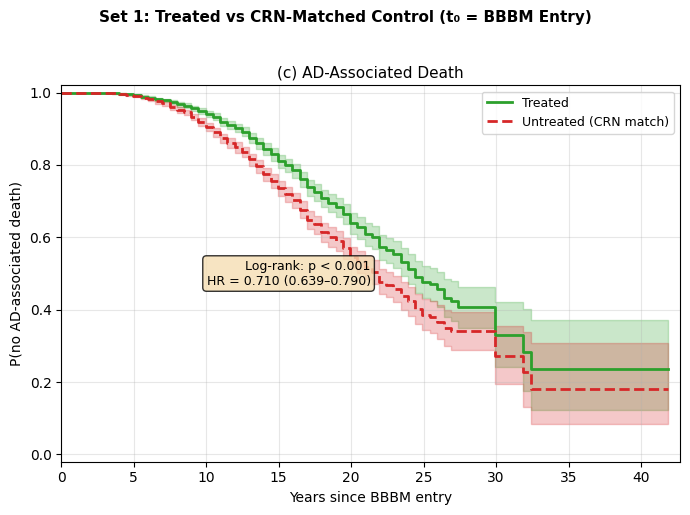


=== Set 1 Results ===
mci                 : HR = 0.612 (0.578–0.647), log-rank < 0.001
death               : HR = 0.906 (0.856–0.959), log-rank < 0.001
dementia_death      : HR = 0.710 (0.639–0.790), log-rank < 0.001


In [7]:
titles = [
    '(a) Progression to MCI',
    '(b) All-Cause Death',
    '(c) AD-Associated Death',
]
ylabels = [
    'P(still in BBBM)',
    'P(alive)',
    'P(no AD-associated death)',
]
keys = ['mci', 'death', 'dementia_death']

# Compute shared xlim across all 3 endpoints
max_dur = max(
    pd.concat([km1_data[k]['duration_t'], km1_data[k]['duration_c']]).max()
    for k in keys
)
shared_xlim = (0, max_dur * 1.02)

results_1 = {}
for key, title, ylabel in zip(keys, titles, ylabels):
    d = km1_data[key]
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    results_1[key] = plot_km_pair(
        ax,
        d['duration_t'], d['event_t'],
        d['duration_c'], d['event_c'],
        title=title, ylabel=ylabel,
        xlim=shared_xlim,
    )
    fig.suptitle('Set 1: Treated vs CRN-Matched Control (t₀ = BBBM Entry)',
                 fontsize=11, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

# Print HRs
print('\n=== Set 1 Results ===')
for key in keys:
    r = results_1[key]
    hr = r['hr']
    lo, hi = r['hr_ci']
    p = r['logrank'].p_value
    p_str = f'{p:.4g}' if p >= 0.001 else '< 0.001'
    print(f'{key:20s}: HR = {hr:.3f} ({lo:.3f}\u2013{hi:.3f}), log-rank {p_str}')

In [8]:
# Compare MCI progression HR to the assumed treatment RR
hr_mci = results_1['mci']['hr']
hr_lo, hr_hi = results_1['mci']['hr_ci']

print('=== MCI Progression: Observed HR vs Assumed RR ===')
print(f'  Assumed treatment RR:      {TREATMENT_RR:.3f}')
print(f'  Observed Cox PH HR:        {hr_mci:.3f} ({hr_lo:.3f}\u2013{hr_hi:.3f})')
print(f'  Ratio (HR / RR):           {hr_mci / TREATMENT_RR:.3f}')
print()
print('The observed HR is attenuated toward 1.0 relative to the RR.')
print('This is expected because the HR reflects the AVERAGE hazard ratio')
print('across all person-time, but treatment is not always active:')
print()
print('  1. waiting_for_treatment period (RR = 1.0, ~1 step)')
print('  2. no_effect_after_treatment (RR = 1.0, after treatment ends)')
print('  3. waning_effect (RR between 0.528 and 1.0)')
print('  4. Deaths in BBBM are censored (not events), but they dilute')
print('     the at-risk population equally in both arms')
print()
print('Only during treatment_effect is the full RR = 0.528 applied.')
print('The KM/Cox framework averages over protected + unprotected')
print('person-time, pulling the HR toward 1.0.')

=== MCI Progression: Observed HR vs Assumed RR ===
  Assumed treatment RR:      0.528
  Observed Cox PH HR:        0.612 (0.578–0.647)
  Ratio (HR / RR):           1.159

The observed HR is attenuated toward 1.0 relative to the RR.
This is expected because the HR reflects the AVERAGE hazard ratio
across all person-time, but treatment is not always active:

  1. waiting_for_treatment period (RR = 1.0, ~1 step)
  2. no_effect_after_treatment (RR = 1.0, after treatment ends)
  3. waning_effect (RR between 0.528 and 1.0)
  4. Deaths in BBBM are censored (not events), but they dilute
     the at-risk population equally in both arms

Only during treatment_effect is the full RR = 0.528 applied.
The KM/Cox framework averages over protected + unprotected
person-time, pulling the HR toward 1.0.


## KM Curve Set 2: Time Zero = Treatment Decision

**Within the treatment scenario**, compare simulants who accepted treatment
(entered `waiting_for_treatment` pipeline) vs those who refused
(entered `no_effect_never_treated`).

Time zero = when the simulant made the treatment decision.

**Caveat**: This is an observational comparison. Simulants are assigned to treatment
vs refusal based on `treatment_propensity`, which could confound if propensity
correlates with other risk factors (though in this model it's random).

In [9]:
def build_km_data_set2(treat_data, sim_end):
    """Build KM-ready DataFrames for Set 2 (time zero = treatment decision).
    
    Treated group: simulants who entered the treatment pipeline.
    Refused group: simulants who entered no_effect_never_treated.
    """
    records = {'mci': [], 'death': [], 'dementia_death': []}

    # Combine both groups
    all_sids = []
    for sid, t0 in treat_data['treatment_pipeline_time'].items():
        all_sids.append((sid, t0, 'treated'))
    for sid, t0 in treat_data['treatment_refusal_time'].items():
        # Only include refusers who were in BBBM
        if sid in treat_data['bbbm_enter_time']:
            all_sids.append((sid, t0, 'refused'))

    for sid, t0, group in all_sids:
        bbbm_exit = treat_data['bbbm_exit_time'].get(sid)
        bbbm_dest = treat_data['bbbm_exit_to'].get(sid)
        death = treat_data['death_time'].get(sid)
        disease_dead = treat_data['disease_at_death'].get(sid)

        # (a) MCI progression
        if bbbm_dest == 'mci' and bbbm_exit is not None:
            dur = (bbbm_exit - t0).days / 365.25
            evt = 1
        elif bbbm_dest == 'dead' and bbbm_exit is not None:
            dur = (bbbm_exit - t0).days / 365.25
            evt = 0
        else:
            dur = (sim_end - t0).days / 365.25
            evt = 0
        if dur > 0:
            records['mci'].append({'duration': dur, 'event': evt, 'group': group})

        # (b) All-cause death
        if death is not None:
            dur = (death - t0).days / 365.25
            evt = 1
        else:
            dur = (sim_end - t0).days / 365.25
            evt = 0
        if dur > 0:
            records['death'].append({'duration': dur, 'event': evt, 'group': group})

        # (c) AD-associated death
        if death is not None and disease_dead == DEMENTIA_STATE:
            dur = (death - t0).days / 365.25
            evt = 1
        elif death is not None:
            dur = (death - t0).days / 365.25
            evt = 0
        else:
            dur = (sim_end - t0).days / 365.25
            evt = 0
        if dur > 0:
            records['dementia_death'].append({'duration': dur, 'event': evt, 'group': group})

    return {k: pd.DataFrame(v) for k, v in records.items()}

km2_data = build_km_data_set2(treat_data, sim_end)
for name, d in km2_data.items():
    n_treated = (d['group'] == 'treated').sum()
    n_refused = (d['group'] == 'refused').sum()
    print(f'{name:20s}: treated={n_treated}, refused={n_refused}')

mci                 : treated=3906, refused=5420
death               : treated=3906, refused=5420
dementia_death      : treated=3906, refused=5420


In [10]:
def plot_km_set2(ax, data, title='', ylabel='Survival probability', xlim=None):
    """Plot KM curves for treated vs refused within treatment scenario, with HR."""
    kmf_t = KaplanMeierFitter()
    kmf_r = KaplanMeierFitter()

    t_mask = data['group'] == 'treated'
    r_mask = data['group'] == 'refused'

    kmf_t.fit(data.loc[t_mask, 'duration'], data.loc[t_mask, 'event'], label='Treated')
    kmf_r.fit(data.loc[r_mask, 'duration'], data.loc[r_mask, 'event'], label='Refused')

    kmf_t.plot_survival_function(ax=ax, color='#2ca02c', linewidth=2)
    kmf_r.plot_survival_function(ax=ax, color='#ff7f0e', linewidth=2, linestyle='--')

    lr_result = logrank_test(
        data.loc[t_mask, 'duration'], data.loc[r_mask, 'duration'],
        data.loc[t_mask, 'event'], data.loc[r_mask, 'event'],
    )
    p = lr_result.p_value
    p_str = 'p < 0.001' if p < 0.001 else f'p = {p:.3f}'

    # Cox PH hazard ratio (treated=1, refused=0)
    hr, hr_lo, hr_hi, cph = compute_hr(
        data.loc[t_mask, 'duration'], data.loc[t_mask, 'event'],
        data.loc[r_mask, 'duration'], data.loc[r_mask, 'event'],
    )

    ax.text(0.98, 0.5,
            f'Log-rank: {p_str}\nHR = {hr:.3f} ({hr_lo:.3f}\u2013{hr_hi:.3f})',
            transform=ax.transAxes, ha='right', va='center', fontsize=9,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='wheat', alpha=0.8))

    ax.set_title(title, fontsize=11)
    ax.set_xlabel('Years since treatment decision')
    ax.set_ylabel(ylabel)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.02, 1.02)
    if xlim is not None:
        ax.set_xlim(xlim)

    return {'logrank': lr_result, 'hr': hr, 'hr_ci': (hr_lo, hr_hi), 'cph': cph}

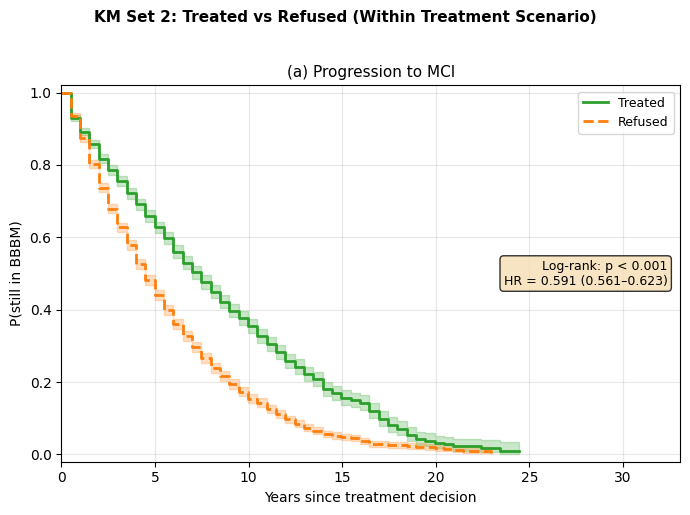

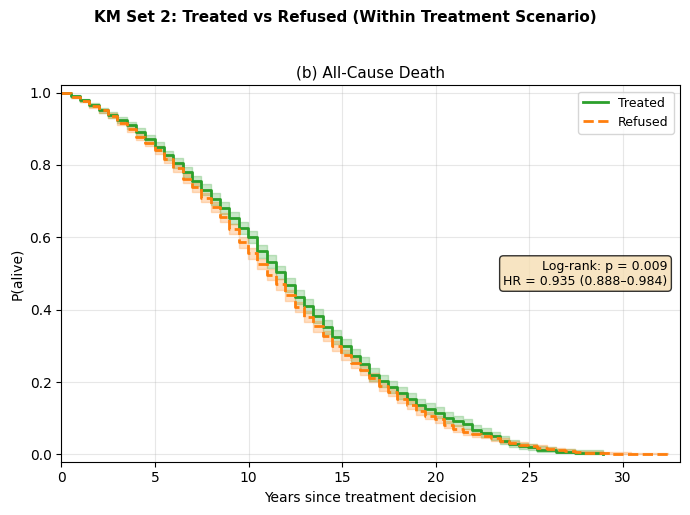

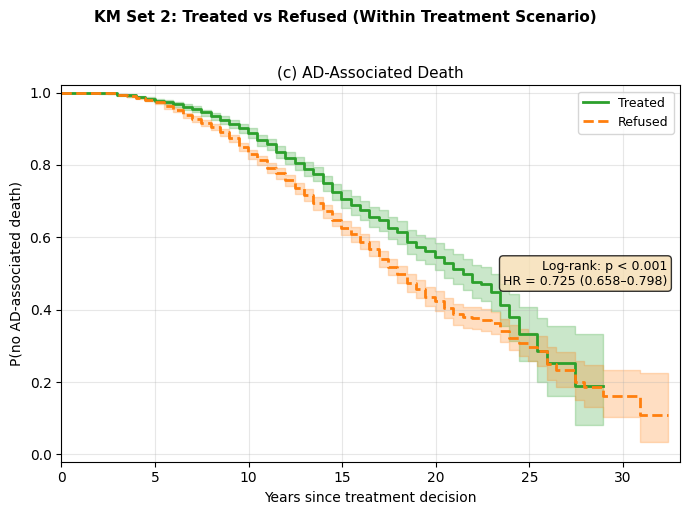


--- Log-rank test results ---
mci                 : chi2= 398.28, p=1.302e-88
death               : chi2=   6.75, p=0.009361
dementia_death      : chi2=  43.39, p=4.485e-11

--- Cox PH Hazard Ratios (treated vs refused) ---
Event                      HR             95% CI
mci                     0.591  (0.561–0.623)
death                   0.935  (0.888–0.984)
dementia_death          0.725  (0.658–0.798)

Note: Treated vs Refused is an observational comparison (not CRN-matched).
Treatment propensity is random in this model, so confounding should be minimal.
The MCI HR here should also be attenuated vs the true RR for the same reasons as Set 1.


In [11]:
titles = [
    '(a) Progression to MCI',
    '(b) All-Cause Death',
    '(c) AD-Associated Death',
]
ylabels = [
    'P(still in BBBM)',
    'P(alive)',
    'P(no AD-associated death)',
]
keys = ['mci', 'death', 'dementia_death']

# Compute shared xlim across all 3 endpoints
max_dur = max(km2_data[k]['duration'].max() for k in keys)
shared_xlim = (0, max_dur * 1.02)

results_2 = {}
for key, title, ylabel in zip(keys, titles, ylabels):
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    results_2[key] = plot_km_set2(
        ax, km2_data[key], title=title, ylabel=ylabel, xlim=shared_xlim,
    )
    fig.suptitle('KM Set 2: Treated vs Refused (Within Treatment Scenario)',
                 fontsize=11, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

print('\n--- Log-rank test results ---')
for key in keys:
    r = results_2[key]
    lr = r['logrank']
    print(f'{key:20s}: chi2={lr.test_statistic:7.2f}, p={lr.p_value:.4g}')

print('\n--- Cox PH Hazard Ratios (treated vs refused) ---')
print(f'{"Event":20s}  {"HR":>7s}  {"95% CI":>17s}')
for key in keys:
    r = results_2[key]
    hr = r['hr']
    lo, hi = r['hr_ci']
    print(f'{key:20s}  {hr:7.3f}  ({lo:.3f}\u2013{hi:.3f})')
print()
print('Note: Treated vs Refused is an observational comparison (not CRN-matched).')
print('Treatment propensity is random in this model, so confounding should be minimal.')
print('The MCI HR here should also be attenuated vs the true RR for the same reasons as Set 1.')

## Sankey Diagram: Why 71.8% Show Zero Benefit

Flow diagram tracing all uncensored treated simulants from BBBM entry
through treatment state to outcome (zero benefit vs has benefit).

Uses CRN-matched comparison: a simulant has "zero benefit" if their BBBM
duration is identical in both scenarios (additional_years == 0).

In [12]:
# Compute additional years for each treated simulant (uncensored only)
sankey_rows = []
for _, row in treated_df.iterrows():
    if row['bbbm_censored_t'] or row['bbbm_censored_c']:
        continue  # skip censored

    dur_t = (row['bbbm_exit_t'] - row['bbbm_enter_t']).days / 365.25
    dur_c = (row['bbbm_exit_c'] - row['bbbm_enter_c']).days / 365.25
    additional = dur_t - dur_c

    sankey_rows.append({
        'sid': row['sid'],
        'additional_years': additional,
        'has_benefit': additional > 0,
        'exit_to_t': row['bbbm_exit_to_t'],
        'tx_state_at_exit': row['tx_state_at_exit'],
    })

sankey_df = pd.DataFrame(sankey_rows)
n_total = len(sankey_df)
n_zero = (sankey_df['additional_years'] == 0).sum()
n_benefit = (sankey_df['additional_years'] > 0).sum()
print(f'Uncensored treated: {n_total}')
print(f'  Zero benefit: {n_zero} ({n_zero/n_total*100:.1f}%)')
print(f'  Has benefit:  {n_benefit} ({n_benefit/n_total*100:.1f}%)')

print(f'\nBBBM exit destination (treatment scenario):')
print(sankey_df['exit_to_t'].value_counts().to_string())

print(f'\nTreatment state at BBBM exit:')
print(sankey_df['tx_state_at_exit'].value_counts().to_string())

Uncensored treated: 3032
  Zero benefit: 2177 (71.8%)
  Has benefit:  855 (28.2%)

BBBM exit destination (treatment scenario):
exit_to_t
mci     2193
dead     839

Treatment state at BBBM exit:
tx_state_at_exit
treatment_effect             1583
waning_effect                1001
waiting_for_treatment         340
no_effect_after_treatment     108


In [13]:
# Categorize simulants for the Sankey diagram
# Level 1: All uncensored treated → Died in BBBM vs Alive MCI transition
died_bbbm = sankey_df[sankey_df['exit_to_t'] == 'dead']
alive_mci = sankey_df[sankey_df['exit_to_t'] == 'mci']

# Level 2 (for alive MCI): Treatment state at exit
# No protection (RR=1.0): waiting_for_treatment, no_effect_after_treatment
no_protection_states = ['waiting_for_treatment', 'no_effect_after_treatment', 'susceptible_to_treatment']
active_states = ['treatment_effect', 'waning_effect']

mci_no_protection = alive_mci[alive_mci['tx_state_at_exit'].isin(no_protection_states)]
mci_active = alive_mci[alive_mci['tx_state_at_exit'].isin(active_states)]

# Level 3 (for active treatment MCI exits): Zero benefit vs Has benefit
mci_active_zero = mci_active[~mci_active['has_benefit']]
mci_active_benefit = mci_active[mci_active['has_benefit']]

# Sanity check: no-protection should all be zero benefit
mci_no_prot_zero = mci_no_protection[~mci_no_protection['has_benefit']]
mci_no_prot_benefit = mci_no_protection[mci_no_protection['has_benefit']]

print('=== Sankey Flow Counts ===')
print(f'Total uncensored treated:            {n_total}')
print(f'  Died in BBBM:                      {len(died_bbbm)}')
print(f'  Alive → MCI transition:            {len(alive_mci)}')
print(f'    No protection (RR=1.0):          {len(mci_no_protection)}')
for state in no_protection_states:
    c = len(mci_no_protection[mci_no_protection['tx_state_at_exit'] == state])
    if c > 0:
        print(f'      {state}: {c}')
print(f'    Active treatment (RR<1.0):       {len(mci_active)}')
for state in active_states:
    c = len(mci_active[mci_active['tx_state_at_exit'] == state])
    if c > 0:
        print(f'      {state}: {c}')
print(f'      → Zero benefit (draw < p_treat): {len(mci_active_zero)}')
print(f'      → Has benefit (rescued):         {len(mci_active_benefit)}')
print(f'    No-protection with benefit:       {len(mci_no_prot_benefit)} (should be ~0)')

# Summary
total_zero = len(died_bbbm) + len(mci_no_prot_zero) + len(mci_active_zero)
total_benefit = len(mci_active_benefit) + len(mci_no_prot_benefit)
print(f'\nTotal zero benefit: {total_zero} ({total_zero/n_total*100:.1f}%)')
print(f'Total has benefit:  {total_benefit} ({total_benefit/n_total*100:.1f}%)')

=== Sankey Flow Counts ===
Total uncensored treated:            3032
  Died in BBBM:                      839
  Alive → MCI transition:            2193
    No protection (RR=1.0):          379
      waiting_for_treatment: 299
      no_effect_after_treatment: 80
    Active treatment (RR<1.0):       1814
      treatment_effect: 1161
      waning_effect: 653
      → Zero benefit (draw < p_treat): 1265
      → Has benefit (rescued):         549
    No-protection with benefit:       26 (should be ~0)

Total zero benefit: 2457 (81.0%)
Total has benefit:  575 (19.0%)


In [14]:
# Build Sankey diagram with plotly
# Nodes:
#  0: All Uncensored Treated
#  1: Died in BBBM
#  2: Alive → MCI
#  3: No Protection (RR=1.0)
#  4: Active Treatment (RR<1.0)
#  5: Zero Benefit
#  6: Has Benefit

labels = [
    f'All Uncensored Treated\n(n={n_total})',       # 0
    f'Died in BBBM\n(n={len(died_bbbm)})',          # 1
    f'Alive MCI Transition\n(n={len(alive_mci)})',   # 2
    f'No Protection (RR=1.0)\n(n={len(mci_no_protection)})',  # 3
    f'Active Treatment (RR<1.0)\n(n={len(mci_active)})',      # 4
    f'Zero Benefit\n(n={total_zero})',               # 5
    f'Has Benefit\n(n={total_benefit})',              # 6
]

# Links: source → target with value
sources = [0, 0, 2, 2, 1, 3, 3, 4, 4]
targets = [1, 2, 3, 4, 5, 5, 6, 5, 6]
values = [
    len(died_bbbm),         # 0→1: All treated → Died in BBBM
    len(alive_mci),         # 0→2: All treated → Alive MCI
    len(mci_no_protection), # 2→3: Alive MCI → No Protection
    len(mci_active),        # 2→4: Alive MCI → Active Treatment
    len(died_bbbm),         # 1→5: Died in BBBM → Zero Benefit
    len(mci_no_prot_zero),  # 3→5: No Protection → Zero Benefit
    len(mci_no_prot_benefit),  # 3→6: No Protection → Has Benefit
    len(mci_active_zero),   # 4→5: Active Treatment → Zero Benefit
    len(mci_active_benefit),# 4→6: Active Treatment → Has Benefit
]

# Colors
node_colors = [
    '#3498db',  # All treated - blue
    '#95a5a6',  # Died in BBBM - gray
    '#3498db',  # Alive MCI - blue
    '#e67e22',  # No protection - orange
    '#2ecc71',  # Active treatment - green
    '#e74c3c',  # Zero benefit - red
    '#27ae60',  # Has benefit - dark green
]

link_colors = [
    'rgba(149,165,166,0.4)',  # → Died
    'rgba(52,152,219,0.4)',   # → Alive MCI
    'rgba(230,126,34,0.4)',   # → No Protection
    'rgba(46,204,113,0.4)',   # → Active Treatment
    'rgba(231,76,60,0.4)',    # Died → Zero
    'rgba(231,76,60,0.4)',    # No Prot → Zero
    'rgba(39,174,96,0.4)',    # No Prot → Benefit
    'rgba(231,76,60,0.4)',    # Active → Zero
    'rgba(39,174,96,0.4)',    # Active → Benefit
]

fig = go.Figure(data=[go.Sankey(
    arrangement='snap',
    node=dict(
        pad=20,
        thickness=25,
        label=labels,
        color=node_colors,
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color=link_colors,
    ),
)])

fig.update_layout(
    title=dict(
        text='Why 71.8% of Treated Simulants Show Zero Additional Preclinical Years',
        font=dict(size=16),
    ),
    font=dict(size=12),
    width=900,
    height=500,
)
fig.show()

## "As-Treated" Subanalysis: HR During Full Treatment Effect Only

The overall HR (0.61) is attenuated because it averages over person-time with
different effective RRs. To recover the assumed RR of 0.528, we restrict to:

- **Treated group**: only person-time during the `treatment_effect` state (RR = 0.528)
  - Time zero = entry to `treatment_effect`
  - Censored at: exit from `treatment_effect` (entering `waning_effect`), death, or sim-end
  - Event = MCI transition during the `treatment_effect` window
- **Refused group**: simulants who entered `no_effect_never_treated` (RR = 1.0)
  - Time zero = refusal time
  - Censored at: death or sim-end
  - Event = MCI transition

This requires re-running the treatment scenario with tracking of `treatment_effect`
entry and exit times.

In [15]:
def run_treatment_state_tracking(target_year=TARGET_YEAR):
    """Re-run treatment scenario tracking treatment_effect entry/exit times."""
    sim = InteractiveContext(
        SPEC_PATH,
        configuration={
            'population': {'population_size': POPULATION_SIZE},
            'intervention': {'scenario': 'bbbm_testing_and_treatment'},
        }
    )

    target = pd.Timestamp(f'{target_year}-01-01')
    est_steps = max(1, math.ceil((target - sim.current_time).days / STEP_SIZE_DAYS))

    in_bbbm = set()
    alive_set = set()
    bbbm_enter_time = {}
    bbbm_exit_time = {}
    bbbm_exit_to = {}
    death_time = {}
    disease_at_death = {}         # sid -> cause of death

    # Treatment state tracking
    treatment_effect_start = {}   # sid -> time entering treatment_effect
    treatment_effect_end = {}     # sid -> time leaving treatment_effect (entering waning/no_effect)
    refusal_time = {}             # sid -> time entering no_effect_never_treated
    prev_treatment = {}           # sid -> treatment state at previous step

    with tqdm(total=est_steps, desc='as-treated tracking', unit='step') as pbar:
        while sim.current_time < target:
            sim.step()
            pop = sim.get_population()
            alive = pop[pop['alive'] == 'alive']
            t = sim.current_time
            current_alive = set(alive.index)

            # Track deaths
            for sid in alive_set - current_alive:
                if sid not in death_time:
                    death_time[sid] = t
                    if sid in pop.index:
                        disease_at_death[sid] = pop.loc[sid, 'cause_of_death']

            # Track BBBM
            currently_bbbm = set(alive.index[alive[DISEASE_COL] == BBBM_STATE])
            for sid in currently_bbbm - in_bbbm:
                if sid not in bbbm_enter_time:
                    bbbm_enter_time[sid] = t
            for sid in in_bbbm - currently_bbbm:
                if sid not in bbbm_exit_time:
                    bbbm_exit_time[sid] = t
                    bbbm_exit_to[sid] = 'mci' if sid in current_alive else 'dead'
            in_bbbm = currently_bbbm
            alive_set = current_alive

            # Track treatment state transitions
            for sid in alive.index:
                state = alive.loc[sid, TREATMENT_COL]
                prev = prev_treatment.get(sid)

                # Entered treatment_effect
                if state == 'treatment_effect' and prev != 'treatment_effect':
                    if sid not in treatment_effect_start:
                        treatment_effect_start[sid] = t

                # Left treatment_effect
                if prev == 'treatment_effect' and state != 'treatment_effect':
                    if sid not in treatment_effect_end:
                        treatment_effect_end[sid] = t

                # Refused treatment
                if state == 'no_effect_never_treated' and sid not in refusal_time:
                    refusal_time[sid] = t

                prev_treatment[sid] = state

            # Also check dead simulants for treatment_effect exits
            for sid in (alive_set | set(prev_treatment.keys())) - current_alive:
                prev = prev_treatment.get(sid)
                if prev == 'treatment_effect' and sid not in treatment_effect_end:
                    treatment_effect_end[sid] = t

            pbar.update(1)

    return {
        'bbbm_enter_time': bbbm_enter_time,
        'bbbm_exit_time': bbbm_exit_time,
        'bbbm_exit_to': bbbm_exit_to,
        'death_time': death_time,
        'disease_at_death': disease_at_death,
        'treatment_effect_start': treatment_effect_start,
        'treatment_effect_end': treatment_effect_end,
        'refusal_time': refusal_time,
        'sim_end': sim.current_time,
    }

print('Re-running treatment scenario with treatment_effect state tracking...')
at_data = run_treatment_state_tracking()
print(f'  {len(at_data["treatment_effect_start"])} simulants entered treatment_effect')
print(f'  {len(at_data["treatment_effect_end"])} exited treatment_effect')
print(f'  {len(at_data["refusal_time"])} refused treatment')
print(f'  {len(at_data["disease_at_death"])} deaths with cause of death recorded')

Re-running treatment scenario with treatment_effect state tracking...


as-treated tracking:   0%|          | 0/97 [00:00<?, ?step/s]

  3858 simulants entered treatment_effect
  3120 exited treatment_effect
  5487 refused treatment
  80497 deaths with cause of death recorded


In [16]:
# Build as-treated KM data for all 3 endpoints: MCI, death, dementia_death
# Uses at_data from run_treatment_state_tracking() (treatment_effect censoring only)
at_sim_end = at_data['sim_end']

def build_single_at_km(data, endpoint='mci'):
    """Build as-treated KM data for a single endpoint with treatment_effect censoring.
    
    endpoint: 'mci' | 'death' | 'dementia_death'
    """
    records = []

    # --- Treated group: only treatment_effect window ---
    for sid, te_start in data['treatment_effect_start'].items():
        bbbm_exit = data['bbbm_exit_time'].get(sid)
        bbbm_dest = data['bbbm_exit_to'].get(sid)
        death = data['death_time'].get(sid)
        te_end = data['treatment_effect_end'].get(sid)
        disease_dead = data['disease_at_death'].get(sid)

        bbbm_enter = data['bbbm_enter_time'].get(sid)
        if bbbm_enter is None or bbbm_enter > te_start:
            continue
        if bbbm_exit is not None and bbbm_exit <= te_start:
            continue

        # End of observation = earliest of: treatment_effect_end, death, sim_end
        # For MCI endpoint, also censor at bbbm_exit (death in BBBM)
        end_times = [data['sim_end']]
        if te_end is not None:
            end_times.append(te_end)
        if death is not None:
            end_times.append(death)
        if endpoint == 'mci' and bbbm_exit is not None:
            end_times.append(bbbm_exit)
        obs_end = min(end_times)

        dur = (obs_end - te_start).days / 365.25
        if dur <= 0:
            continue

        if endpoint == 'mci':
            if (bbbm_exit is not None and bbbm_dest == 'mci'
                    and bbbm_exit <= obs_end
                    and (te_end is None or bbbm_exit <= te_end)):
                evt = 1
            else:
                evt = 0
        elif endpoint == 'death':
            if death is not None and death <= obs_end:
                evt = 1
            else:
                evt = 0
        elif endpoint == 'dementia_death':
            if death is not None and death <= obs_end and disease_dead == DEMENTIA_STATE:
                evt = 1
            else:
                evt = 0

        records.append({'duration': dur, 'event': evt, 'group': 'treated'})

    # --- Refused group: all person-time from refusal ---
    for sid, ref_time in data['refusal_time'].items():
        bbbm_exit = data['bbbm_exit_time'].get(sid)
        bbbm_dest = data['bbbm_exit_to'].get(sid)
        death = data['death_time'].get(sid)
        disease_dead = data['disease_at_death'].get(sid)

        bbbm_enter = data['bbbm_enter_time'].get(sid)
        if bbbm_enter is None or bbbm_enter > ref_time:
            continue
        if bbbm_exit is not None and bbbm_exit <= ref_time:
            continue

        end_times = [data['sim_end']]
        if death is not None:
            end_times.append(death)
        if endpoint == 'mci' and bbbm_exit is not None:
            end_times.append(bbbm_exit)
        obs_end = min(end_times)

        dur = (obs_end - ref_time).days / 365.25
        if dur <= 0:
            continue

        if endpoint == 'mci':
            if bbbm_exit is not None and bbbm_dest == 'mci' and bbbm_exit <= obs_end:
                evt = 1
            else:
                evt = 0
        elif endpoint == 'death':
            if death is not None and death <= obs_end:
                evt = 1
            else:
                evt = 0
        elif endpoint == 'dementia_death':
            if death is not None and death <= obs_end and disease_dead == DEMENTIA_STATE:
                evt = 1
            else:
                evt = 0

        records.append({'duration': dur, 'event': evt, 'group': 'refused'})

    return pd.DataFrame(records)


# Build for all 3 endpoints
at_endpoints = ['mci', 'death', 'dementia_death']
at_dfs = {}
for ep in at_endpoints:
    at_dfs[ep] = build_single_at_km(at_data, endpoint=ep)
    df = at_dfs[ep]
    t_m = df['group'] == 'treated'
    r_m = df['group'] == 'refused'
    print(f'{ep:20s}: treated={t_m.sum()} ({df.loc[t_m, "event"].sum()} events),'
          f' refused={r_m.sum()} ({df.loc[r_m, "event"].sum()} events)')

mci                 : treated=3491 (1161 events), refused=5420 (4036 events)
death               : treated=3491 (595 events), refused=5420 (3945 events)
dementia_death      : treated=3491 (67 events), refused=5420 (1328 events)


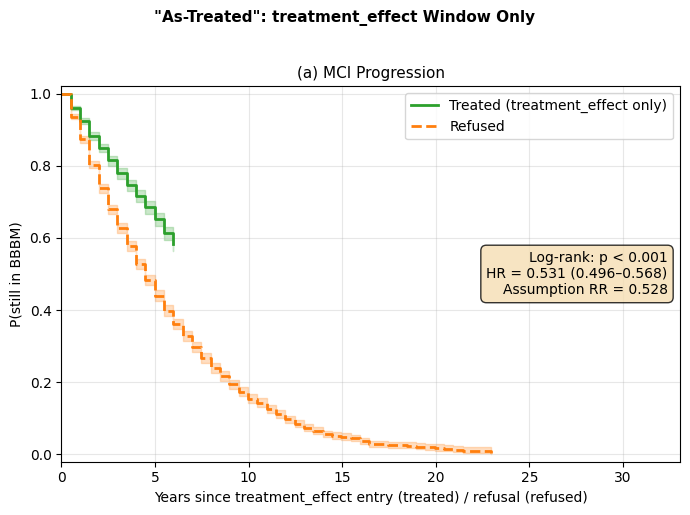

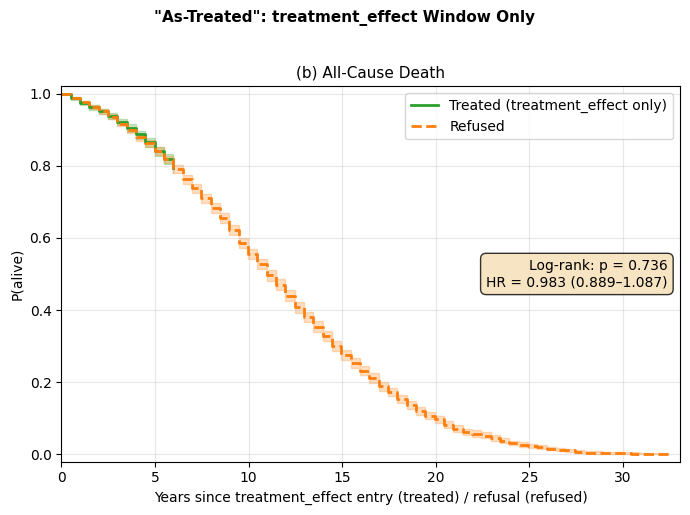

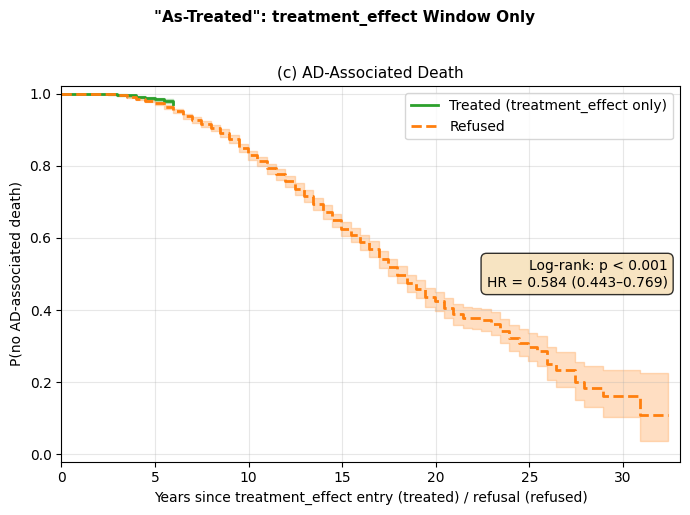


=== As-Treated Results (treatment_effect window only) ===
Endpoint                   HR             95% CI    Log-rank p
mci                     0.531  (0.496–0.568)       < 0.001
death                   0.983  (0.889–1.087)        0.7359
dementia_death          0.584  (0.443–0.769)       < 0.001

MCI HR matches assumed RR (within 0.05): YES (difference = +0.003)


In [17]:
# KM plots + HR for as-treated analysis: 3 individual figures with shared axes
at_titles = {
    'mci': '(a) MCI Progression',
    'death': '(b) All-Cause Death',
    'dementia_death': '(c) AD-Associated Death',
}
at_ylabels = {
    'mci': 'P(still in BBBM)',
    'death': 'P(alive)',
    'dementia_death': 'P(no AD-associated death)',
}

# Compute shared xlim across all 3 endpoints
max_dur = max(at_dfs[ep]['duration'].max() for ep in at_endpoints)
shared_xlim = (0, max_dur * 1.02)

at_results_single = {}
for ep in at_endpoints:
    df = at_dfs[ep]
    t_mask = df['group'] == 'treated'
    r_mask = df['group'] == 'refused'

    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    kmf_t = KaplanMeierFitter()
    kmf_r = KaplanMeierFitter()
    kmf_t.fit(df.loc[t_mask, 'duration'], df.loc[t_mask, 'event'],
              label='Treated (treatment_effect only)')
    kmf_r.fit(df.loc[r_mask, 'duration'], df.loc[r_mask, 'event'],
              label='Refused')
    kmf_t.plot_survival_function(ax=ax, color='#2ca02c', linewidth=2)
    kmf_r.plot_survival_function(ax=ax, color='#ff7f0e', linewidth=2, linestyle='--')

    lr = logrank_test(
        df.loc[t_mask, 'duration'], df.loc[r_mask, 'duration'],
        df.loc[t_mask, 'event'], df.loc[r_mask, 'event'],
    )
    hr, hr_lo, hr_hi, cph = compute_hr(
        df.loc[t_mask, 'duration'], df.loc[t_mask, 'event'],
        df.loc[r_mask, 'duration'], df.loc[r_mask, 'event'],
    )

    p_str = 'p < 0.001' if lr.p_value < 0.001 else f'p = {lr.p_value:.3f}'
    annotation = f'Log-rank: {p_str}\nHR = {hr:.3f} ({hr_lo:.3f}\u2013{hr_hi:.3f})'
    if ep == 'mci':
        annotation += f'\nAssumption RR = {TREATMENT_RR:.3f}'
    ax.text(0.98, 0.5, annotation,
            transform=ax.transAxes, ha='right', va='center', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.4', facecolor='wheat', alpha=0.8))

    ax.set_title(at_titles[ep], fontsize=11)
    ax.set_xlabel('Years since treatment_effect entry (treated) / refusal (refused)')
    ax.set_ylabel(at_ylabels[ep])
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.02, 1.02)
    ax.set_xlim(shared_xlim)
    fig.suptitle('"As-Treated": treatment_effect Window Only',
                 fontsize=11, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

    at_results_single[ep] = {'hr': hr, 'hr_ci': (hr_lo, hr_hi),
                              'logrank': lr, 'cph': cph}

print(f'\n=== As-Treated Results (treatment_effect window only) ===')
print(f'{"Endpoint":20s}  {"HR":>7s}  {"95% CI":>17s}  {"Log-rank p":>12s}')
for ep in at_endpoints:
    r = at_results_single[ep]
    hr = r['hr']
    lo, hi = r['hr_ci']
    p = r['logrank'].p_value
    p_str = f'{p:.4g}' if p >= 0.001 else '< 0.001'
    print(f'{ep:20s}  {hr:7.3f}  ({lo:.3f}\u2013{hi:.3f})  {p_str:>12s}')

hr_mci = at_results_single['mci']['hr']
match = abs(hr_mci - TREATMENT_RR) < 0.05
print(f'\nMCI HR matches assumed RR (within 0.05): {"YES" if match else "NO"}'
      f' (difference = {hr_mci - TREATMENT_RR:+.3f})')

### Extended: Treatment Effect + Waning Period

The previous analysis censored at `treatment_effect` exit and recovered HR = 0.528.
Now we extend follow-up through `waning_effect` (where RR ramps from 0.528 toward 1.0)
to see how the observed HR degrades as the drug wears off.

This requires re-running with tracking of `waning_effect` exit times.

In [18]:
def run_extended_treatment_tracking(target_year=TARGET_YEAR):
    """Re-run treatment scenario tracking treatment_effect AND waning_effect boundaries."""
    sim = InteractiveContext(
        SPEC_PATH,
        configuration={
            'population': {'population_size': POPULATION_SIZE},
            'intervention': {'scenario': 'bbbm_testing_and_treatment'},
        }
    )

    target = pd.Timestamp(f'{target_year}-01-01')
    est_steps = max(1, math.ceil((target - sim.current_time).days / STEP_SIZE_DAYS))

    in_bbbm = set()
    alive_set = set()
    bbbm_enter_time = {}
    bbbm_exit_time = {}
    bbbm_exit_to = {}
    death_time = {}
    disease_at_death = {}         # sid -> cause of death

    treatment_effect_start = {}
    treatment_effect_end = {}
    waning_effect_end = {}        # NEW: sid -> time leaving waning_effect
    refusal_time = {}
    prev_treatment = {}

    with tqdm(total=est_steps, desc='extended tracking', unit='step') as pbar:
        while sim.current_time < target:
            sim.step()
            pop = sim.get_population()
            alive = pop[pop['alive'] == 'alive']
            t = sim.current_time
            current_alive = set(alive.index)

            # Track deaths
            for sid in alive_set - current_alive:
                if sid not in death_time:
                    death_time[sid] = t
                    if sid in pop.index:
                        disease_at_death[sid] = pop.loc[sid, 'cause_of_death']

            # Track BBBM
            currently_bbbm = set(alive.index[alive[DISEASE_COL] == BBBM_STATE])
            for sid in currently_bbbm - in_bbbm:
                if sid not in bbbm_enter_time:
                    bbbm_enter_time[sid] = t
            for sid in in_bbbm - currently_bbbm:
                if sid not in bbbm_exit_time:
                    bbbm_exit_time[sid] = t
                    bbbm_exit_to[sid] = 'mci' if sid in current_alive else 'dead'
            in_bbbm = currently_bbbm
            alive_set = current_alive

            # Track treatment state transitions
            for sid in alive.index:
                state = alive.loc[sid, TREATMENT_COL]
                prev = prev_treatment.get(sid)

                if state == 'treatment_effect' and prev != 'treatment_effect':
                    if sid not in treatment_effect_start:
                        treatment_effect_start[sid] = t

                if prev == 'treatment_effect' and state != 'treatment_effect':
                    if sid not in treatment_effect_end:
                        treatment_effect_end[sid] = t

                if prev == 'waning_effect' and state != 'waning_effect':
                    if sid not in waning_effect_end:
                        waning_effect_end[sid] = t

                if state == 'no_effect_never_treated' and sid not in refusal_time:
                    refusal_time[sid] = t

                prev_treatment[sid] = state

            # Check dead simulants for state exits
            for sid in set(prev_treatment.keys()) - current_alive:
                prev = prev_treatment.get(sid)
                if prev == 'treatment_effect' and sid not in treatment_effect_end:
                    treatment_effect_end[sid] = t
                if prev == 'waning_effect' and sid not in waning_effect_end:
                    waning_effect_end[sid] = t

            pbar.update(1)

    return {
        'bbbm_enter_time': bbbm_enter_time,
        'bbbm_exit_time': bbbm_exit_time,
        'bbbm_exit_to': bbbm_exit_to,
        'death_time': death_time,
        'disease_at_death': disease_at_death,
        'treatment_effect_start': treatment_effect_start,
        'treatment_effect_end': treatment_effect_end,
        'waning_effect_end': waning_effect_end,
        'refusal_time': refusal_time,
        'sim_end': sim.current_time,
    }

print('Re-running treatment scenario with extended treatment state tracking...')
ext_data = run_extended_treatment_tracking()
print(f'  {len(ext_data["treatment_effect_start"])} entered treatment_effect')
print(f'  {len(ext_data["treatment_effect_end"])} exited treatment_effect \u2192 waning')
print(f'  {len(ext_data["waning_effect_end"])} exited waning_effect \u2192 no_effect')
print(f'  {len(ext_data["refusal_time"])} refused treatment')
print(f'  {len(ext_data["disease_at_death"])} deaths with cause of death recorded')

Re-running treatment scenario with extended treatment state tracking...


extended tracking:   0%|          | 0/97 [00:00<?, ?step/s]

  3858 entered treatment_effect
  3120 exited treatment_effect → waning
  1757 exited waning_effect → no_effect
  5487 refused treatment
  80497 deaths with cause of death recorded


In [19]:
def build_at_km(ext_data, censor_at, endpoint='mci'):
    """Build as-treated KM data with different censoring strategies.
    
    censor_at: 'treatment_effect' | 'waning_effect' | 'none'
    endpoint: 'mci' | 'death' | 'dementia_death'
    """
    sim_end = ext_data['sim_end']
    records = []

    # Treated group
    for sid, te_start in ext_data['treatment_effect_start'].items():
        bbbm_enter = ext_data['bbbm_enter_time'].get(sid)
        bbbm_exit = ext_data['bbbm_exit_time'].get(sid)
        bbbm_dest = ext_data['bbbm_exit_to'].get(sid)
        death = ext_data['death_time'].get(sid)
        disease_dead = ext_data['disease_at_death'].get(sid)
        te_end = ext_data['treatment_effect_end'].get(sid)
        we_end = ext_data['waning_effect_end'].get(sid)

        if bbbm_enter is None or bbbm_enter > te_start:
            continue
        if bbbm_exit is not None and bbbm_exit <= te_start:
            continue

        # Determine observation end based on censoring strategy
        end_times = [sim_end]
        if death is not None:
            end_times.append(death)
        if endpoint == 'mci' and bbbm_exit is not None:
            end_times.append(bbbm_exit)
        if censor_at == 'treatment_effect' and te_end is not None:
            end_times.append(te_end)
        elif censor_at == 'waning_effect' and we_end is not None:
            end_times.append(we_end)
        obs_end = min(end_times)

        dur = (obs_end - te_start).days / 365.25
        if dur <= 0:
            continue

        # Determine event based on endpoint
        if endpoint == 'mci':
            if bbbm_exit is not None and bbbm_dest == 'mci' and bbbm_exit <= obs_end:
                evt = 1
            else:
                evt = 0
        elif endpoint == 'death':
            if death is not None and death <= obs_end:
                evt = 1
            else:
                evt = 0
        elif endpoint == 'dementia_death':
            if death is not None and death <= obs_end and disease_dead == DEMENTIA_STATE:
                evt = 1
            else:
                evt = 0

        records.append({'duration': dur, 'event': evt, 'group': 'treated'})

    # Refused group (same regardless of censoring strategy)
    for sid, ref_time in ext_data['refusal_time'].items():
        bbbm_enter = ext_data['bbbm_enter_time'].get(sid)
        bbbm_exit = ext_data['bbbm_exit_time'].get(sid)
        bbbm_dest = ext_data['bbbm_exit_to'].get(sid)
        death = ext_data['death_time'].get(sid)
        disease_dead = ext_data['disease_at_death'].get(sid)

        if bbbm_enter is None or bbbm_enter > ref_time:
            continue
        if bbbm_exit is not None and bbbm_exit <= ref_time:
            continue

        end_times = [sim_end]
        if death is not None:
            end_times.append(death)
        if endpoint == 'mci' and bbbm_exit is not None:
            end_times.append(bbbm_exit)
        obs_end = min(end_times)

        dur = (obs_end - ref_time).days / 365.25
        if dur <= 0:
            continue

        if endpoint == 'mci':
            if bbbm_exit is not None and bbbm_dest == 'mci' and bbbm_exit <= obs_end:
                evt = 1
            else:
                evt = 0
        elif endpoint == 'death':
            if death is not None and death <= obs_end:
                evt = 1
            else:
                evt = 0
        elif endpoint == 'dementia_death':
            if death is not None and death <= obs_end and disease_dead == DEMENTIA_STATE:
                evt = 1
            else:
                evt = 0

        records.append({'duration': dur, 'event': evt, 'group': 'refused'})

    return pd.DataFrame(records)


# Build all 3 endpoints x 3 censoring strategies = 9 combinations
censor_configs = [
    ('treatment_effect', 'treatment_effect only (RR = 0.528)'),
    ('waning_effect', 'treatment_effect + waning (RR: 0.528 \u2192 1.0)'),
    ('none', 'full pipeline (includes no_effect_after)'),
]
endpoint_list = ['mci', 'death', 'dementia_death']

at_results = {}  # (endpoint, censor_at) -> DataFrame
for ep in endpoint_list:
    for censor_at, label in censor_configs:
        df = build_at_km(ext_data, censor_at, endpoint=ep)
        t_mask = df['group'] == 'treated'
        r_mask = df['group'] == 'refused'
        evt_t = df.loc[t_mask, 'event'].sum()
        evt_r = df.loc[r_mask, 'event'].sum()
        print(f'{ep:18s} | {censor_at:20s}: treated={t_mask.sum()} ({evt_t} events),'
              f' refused={r_mask.sum()} ({evt_r} events)')
        at_results[(ep, censor_at)] = df

mci                | treatment_effect    : treated=3491 (1161 events), refused=5420 (4036 events)
mci                | waning_effect       : treated=3491 (1814 events), refused=5420 (4036 events)
mci                | none                : treated=3491 (1894 events), refused=5420 (4036 events)
death              | treatment_effect    : treated=3491 (595 events), refused=5420 (3945 events)
death              | waning_effect       : treated=3491 (1795 events), refused=5420 (3945 events)
death              | none                : treated=3491 (2105 events), refused=5420 (3945 events)
dementia_death     | treatment_effect    : treated=3491 (67 events), refused=5420 (1328 events)
dementia_death     | waning_effect       : treated=3491 (417 events), refused=5420 (1328 events)
dementia_death     | none                : treated=3491 (507 events), refused=5420 (1328 events)


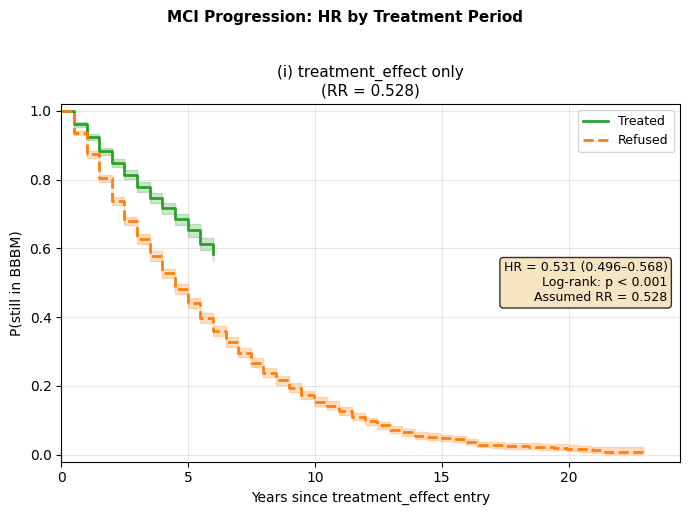

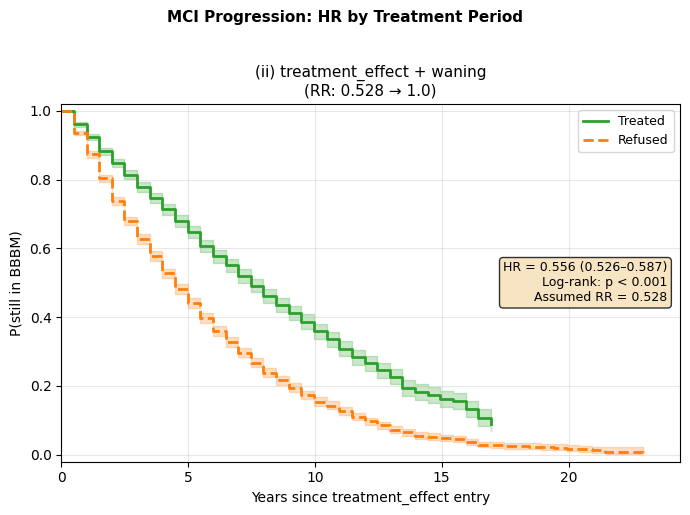

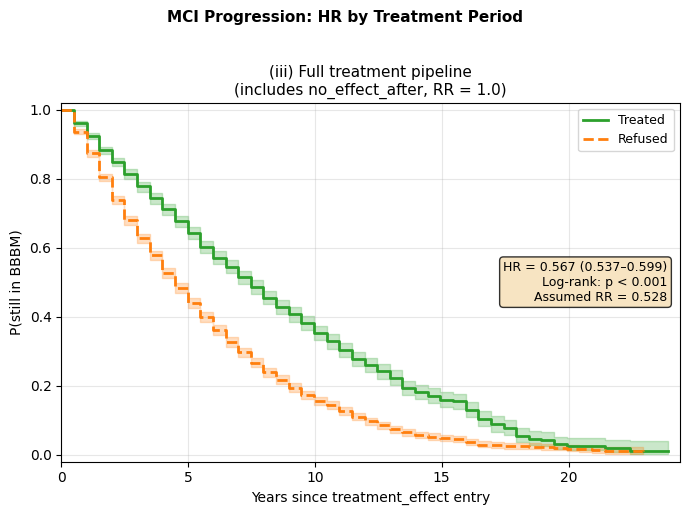

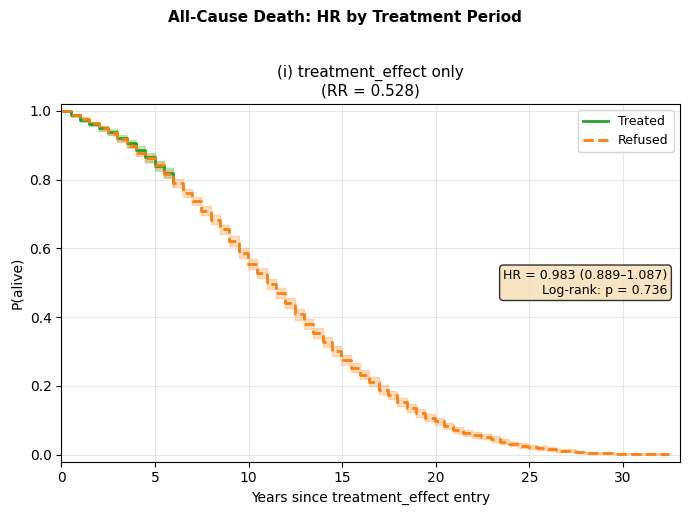

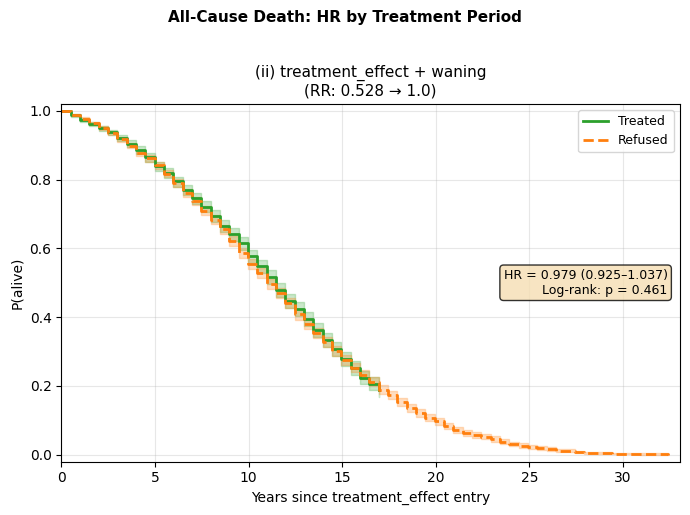

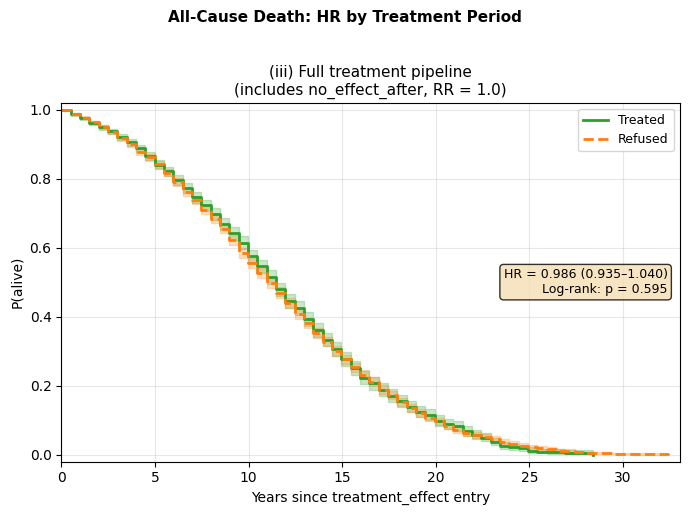

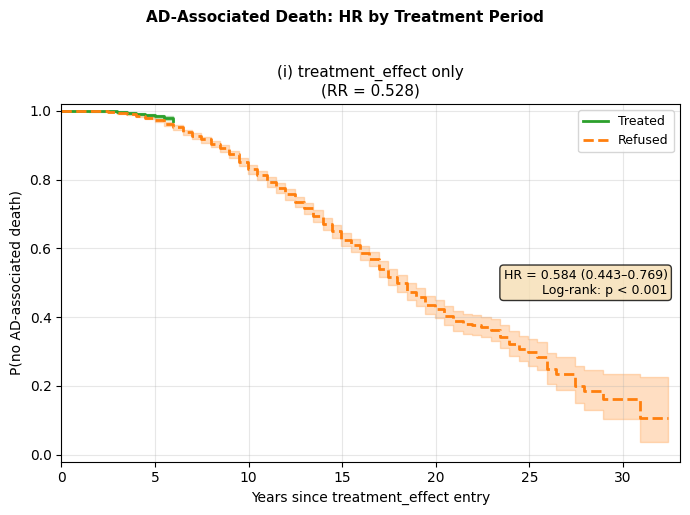

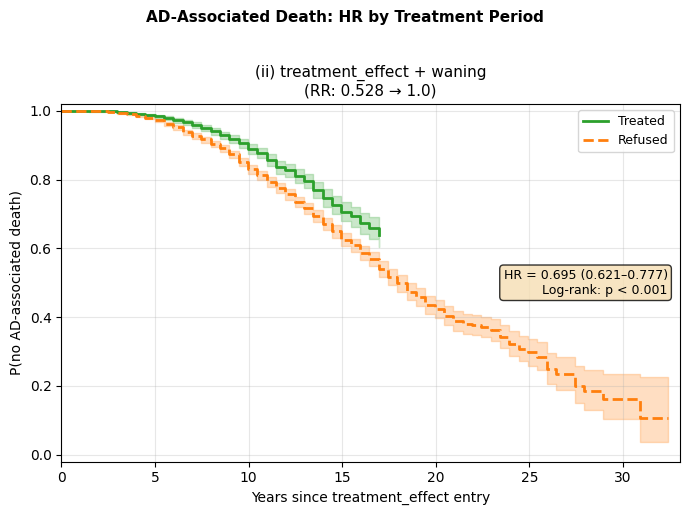

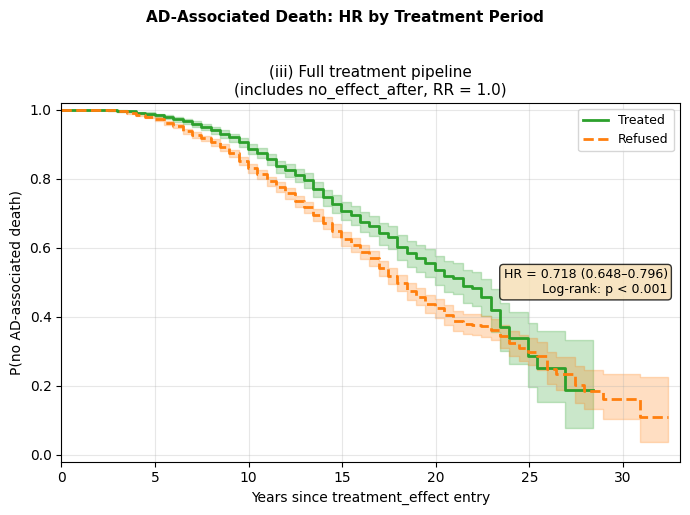


=== HR by Endpoint and Treatment Period ===
Endpoint            Period                                    HR             95% CI
mci                 treatment_effect only                  0.531  (0.496–0.568)
mci                 treatment_effect + waning              0.556  (0.526–0.587)
mci                 full pipeline (incl. no_effect)        0.567  (0.537–0.599)

death               treatment_effect only                  0.983  (0.889–1.087)
death               treatment_effect + waning              0.979  (0.925–1.037)
death               full pipeline (incl. no_effect)        0.986  (0.935–1.040)

dementia_death      treatment_effect only                  0.584  (0.443–0.769)
dementia_death      treatment_effect + waning              0.695  (0.621–0.777)
dementia_death      full pipeline (incl. no_effect)        0.718  (0.648–0.796)



In [20]:
# 9 individual figures: 3 endpoints x 3 censoring strategies
# Grouped by endpoint — flip through censoring strategies to see HR degrade

endpoint_titles = {
    'mci': 'MCI Progression',
    'death': 'All-Cause Death',
    'dementia_death': 'AD-Associated Death',
}
endpoint_ylabels = {
    'mci': 'P(still in BBBM)',
    'death': 'P(alive)',
    'dementia_death': 'P(no AD-associated death)',
}
panel_labels = {
    'treatment_effect': '(i) treatment_effect only\n(RR = 0.528)',
    'waning_effect': '(ii) treatment_effect + waning\n(RR: 0.528 \u2192 1.0)',
    'none': '(iii) Full treatment pipeline\n(includes no_effect_after, RR = 1.0)',
}

hr_summary = {}
for ep in endpoint_list:
    # Compute shared xlim within this endpoint group
    max_dur = max(
        at_results[(ep, ca)]['duration'].max()
        for ca, _ in censor_configs
    )
    shared_xlim = (0, max_dur * 1.02)

    for censor_at, _ in censor_configs:
        df = at_results[(ep, censor_at)]
        t_mask = df['group'] == 'treated'
        r_mask = df['group'] == 'refused'

        fig, ax = plt.subplots(1, 1, figsize=(7, 5))
        kmf_t = KaplanMeierFitter()
        kmf_r = KaplanMeierFitter()
        kmf_t.fit(df.loc[t_mask, 'duration'], df.loc[t_mask, 'event'],
                  label='Treated')
        kmf_r.fit(df.loc[r_mask, 'duration'], df.loc[r_mask, 'event'],
                  label='Refused')
        kmf_t.plot_survival_function(ax=ax, color='#2ca02c', linewidth=2)
        kmf_r.plot_survival_function(ax=ax, color='#ff7f0e', linewidth=2, linestyle='--')

        hr, hr_lo, hr_hi, _ = compute_hr(
            df.loc[t_mask, 'duration'], df.loc[t_mask, 'event'],
            df.loc[r_mask, 'duration'], df.loc[r_mask, 'event'],
        )
        lr = logrank_test(
            df.loc[t_mask, 'duration'], df.loc[r_mask, 'duration'],
            df.loc[t_mask, 'event'], df.loc[r_mask, 'event'],
        )
        p_str = 'p < 0.001' if lr.p_value < 0.001 else f'p = {lr.p_value:.3f}'

        annotation = f'HR = {hr:.3f} ({hr_lo:.3f}\u2013{hr_hi:.3f})\nLog-rank: {p_str}'
        if ep == 'mci':
            annotation += f'\nAssumed RR = {TREATMENT_RR:.3f}'
        ax.text(0.98, 0.5, annotation,
                transform=ax.transAxes, ha='right', va='center', fontsize=9,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='wheat', alpha=0.8))

        ax.set_title(panel_labels[censor_at], fontsize=11)
        ax.set_xlabel('Years since treatment_effect entry')
        ax.set_ylabel(endpoint_ylabels[ep])
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(-0.02, 1.02)
        ax.set_xlim(shared_xlim)
        fig.suptitle(f'{endpoint_titles[ep]}: HR by Treatment Period',
                     fontsize=11, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()

        hr_summary[(ep, censor_at)] = {'hr': hr, 'ci': (hr_lo, hr_hi), 'p': lr.p_value}

# Summary table
print(f'\n=== HR by Endpoint and Treatment Period ===')
print(f'{"Endpoint":18s}  {"Period":35s}  {"HR":>7s}  {"95% CI":>17s}')
for ep in endpoint_list:
    for censor_at, label in [('treatment_effect', 'treatment_effect only'),
                              ('waning_effect', 'treatment_effect + waning'),
                              ('none', 'full pipeline (incl. no_effect)')]:
        r = hr_summary[(ep, censor_at)]
        lo, hi = r['ci']
        hr_val = r['hr']
        print(f'{ep:18s}  {label:35s}  {hr_val:7.3f}  ({lo:.3f}\u2013{hi:.3f})')
    print()

## Summary Statistics

In [21]:
print('=' * 70)
print('KM & SANKEY ANALYSIS SUMMARY')
print('=' * 70)

print(f'\nSimulation: 2022-{TARGET_YEAR}, population={POPULATION_SIZE:,}')
print(f'Assumed treatment RR (BBBM\u2192MCI): {TREATMENT_RR:.3f}')
print(f'Matched treated simulants: {len(treated_df)}')
print(f'  Uncensored (exited BBBM in both scenarios): {n_total}')

print(f'\n--- KM Set 1: Time Zero = BBBM Entry (Treated vs CRN-Matched Untreated) ---')
print(f'{"Event":20s}  {"chi2":>7s}  {"p-value":>12s}  {"HR":>7s}  {"95% CI":>17s}')
for key in ['mci', 'death', 'dementia_death']:
    r = results_1[key]
    lr = r['logrank']
    hr = r['hr']
    lo, hi = r['hr_ci']
    print(f'{key:20s}  {lr.test_statistic:7.2f}  {lr.p_value:12.4g}  {hr:7.3f}  ({lo:.3f}\u2013{hi:.3f})')

print(f'\n--- KM Set 2: Time Zero = Treatment Decision (Treated vs Refused) ---')
print(f'{"Event":20s}  {"chi2":>7s}  {"p-value":>12s}  {"HR":>7s}  {"95% CI":>17s}')
for key in ['mci', 'death', 'dementia_death']:
    r = results_2[key]
    lr = r['logrank']
    hr = r['hr']
    lo, hi = r['hr_ci']
    print(f'{key:20s}  {lr.test_statistic:7.2f}  {lr.p_value:12.4g}  {hr:7.3f}  ({lo:.3f}\u2013{hi:.3f})')

hr_mci_1 = results_1['mci']['hr']
print(f'\n--- Measured HR vs Assumed RR ---')
print(f'  Assumed RR (treatment_effect state):  {TREATMENT_RR:.3f}')
print(f'  Observed HR (MCI, Set 1):                {hr_mci_1:.3f}')
print(f'  Attenuation factor (HR / RR):            {hr_mci_1 / TREATMENT_RR:.3f}')
print(f'  Explanation: HR > RR because the Cox model averages over')
print(f'  all person-time, including periods when RR = 1.0')
print(f'  (waiting_for_treatment, no_effect_after_treatment, waning)')

print(f'\n--- As-Treated: HR by Endpoint and Censoring Strategy ---')
print(f'{"Endpoint":18s}  {"Period":35s}  {"HR":>7s}  {"95% CI":>17s}')
for ep in ['mci', 'death', 'dementia_death']:
    for censor_at, label in [('treatment_effect', 'treatment_effect only'),
                              ('waning_effect', 'treatment_effect + waning'),
                              ('none', 'full pipeline (incl. no_effect)')]:
        r = hr_summary[(ep, censor_at)]
        lo, hi = r['ci']
        hr_val = r['hr']
        print(f'{ep:18s}  {label:35s}  {hr_val:7.3f}  ({lo:.3f}\u2013{hi:.3f})')
    print()

print(f'--- Sankey: Zero-Benefit Breakdown ---')
print(f'  Total uncensored treated:          {n_total}')
print(f'  Died in BBBM \u2192 zero benefit:       {len(died_bbbm):>5d} ({len(died_bbbm)/n_total*100:.1f}%)')
print(f'  No protection (RR=1) \u2192 zero:       {len(mci_no_prot_zero):>5d} ({len(mci_no_prot_zero)/n_total*100:.1f}%)')
print(f'  Active treatment \u2192 zero (CRN):     {len(mci_active_zero):>5d} ({len(mci_active_zero)/n_total*100:.1f}%)')
print(f'  Active treatment \u2192 has benefit:     {len(mci_active_benefit):>5d} ({len(mci_active_benefit)/n_total*100:.1f}%)')
print(f'  \u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500\u2500')
print(f'  Total zero benefit:                {total_zero:>5d} ({total_zero/n_total*100:.1f}%)')
print(f'  Total has benefit:                 {total_benefit:>5d} ({total_benefit/n_total*100:.1f}%)')

KM & SANKEY ANALYSIS SUMMARY

Simulation: 2022-2070, population=10,000
Assumed treatment RR (BBBM→MCI): 0.528
Matched treated simulants: 3969
  Uncensored (exited BBBM in both scenarios): 3032

--- KM Set 1: Time Zero = BBBM Entry (Treated vs CRN-Matched Untreated) ---
Event                    chi2       p-value       HR             95% CI
mci                    292.82      1.21e-65    0.612  (0.578–0.647)
death                   11.59     0.0006644    0.906  (0.856–0.959)
dementia_death          40.44     2.031e-10    0.710  (0.639–0.790)

--- KM Set 2: Time Zero = Treatment Decision (Treated vs Refused) ---
Event                    chi2       p-value       HR             95% CI
mci                    398.28     1.302e-88    0.591  (0.561–0.623)
death                    6.75      0.009361    0.935  (0.888–0.984)
dementia_death          43.39     4.485e-11    0.725  (0.658–0.798)

--- Measured HR vs Assumed RR ---
  Assumed RR (treatment_effect state):  0.528
  Observed HR (MCI, Set 1)